# PyIRI Tutorial: Generating Continuous Ionospheric Time Series Using Daily F10.7

This tutorial demonstrates how to use the **PyIRI** model to compute a time-continuous, solar-index-aware output of key ionospheric parameters (e.g., **NmF2** and **hmF2**) over an entire year.

We combine:

- **Monthly mean climatology** of ionospheric parameters
- **Daily interpolation** between months
- **Solar activity interpolation** using daily **F10.7** solar index values

---

## What you'll learn

- How to load and clean a daily time series of F10.7 solar flux index  
- How to run `PyIRI.main_library.IRI_monthly_mean_par()` for all 12 months  
- How to interpolate ionospheric output across **days** and **hours**  
- How to interpolate between **solar minimum** and **solar maximum** cases using continuous F10.7 input  
- How to visualize the final ionospheric response time series at a specific location

---

## Notes

- You can use **any horizontal grid** (regional or global, regular or irregular).  
- Input coordinate system in this example is **geographic (GEO)**, but QD and MLT inputs are also supported in other PyIRI routines.
- The method is scalable to arbitrary years and resolutions of F10.7 input (daily, monthly, etc.).

---


100%|██████████| 365/365 [00:00<00:00, 16212.92it/s]


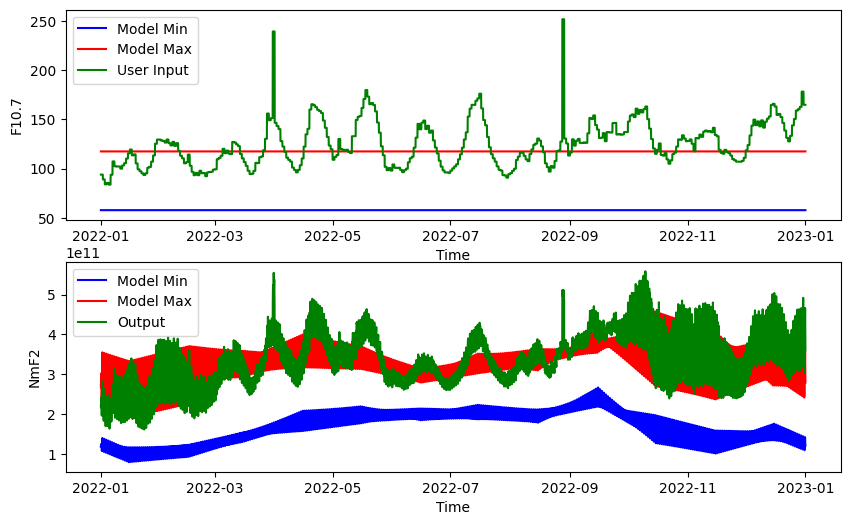

In [14]:
import numpy as np
import PyIRI
import PyIRI.main_library as ml
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import PyIRI.sh_library as sh  # Updated PyIRI using spherical harmonics

# ------------------------------
# Load daily F10.7 time series
# ------------------------------
solar_par = pd.read_pickle('GFZ_geo_solar_2000-2023.pkl')  # Contains F107 index
F107 = solar_par['F107'].copy()
timearray = solar_par.index

# Identify and clean bad values
ind_bad = np.where((F107 < 50) | (F107 > 500))[0]
ind_good = np.where((F107 >= 50) & (F107 <= 500))[0]

if ind_bad.size > 0:
    # Use .iloc to access positions safely
    time_cleaned = timearray[ind_good]
    F107_cleaned = F107.iloc[ind_good]
    
    # Assign using .iloc
    F107.iloc[ind_bad] = np.interp(timearray[ind_bad], time_cleaned, F107_cleaned)

# ------------------------------
# Select year of interest safely
# ------------------------------
year = 2022
a = np.where(solar_par.index.year == year)[0]

# Use .iloc to select by position
F107 = F107.iloc[a].reset_index(drop=True)
timearray = solar_par.index[a]
at_days = np.arange(datetime(year, 1, 1), datetime(year + 1, 1, 1), timedelta(days=1)).astype(datetime)

# ------------------------------
# Set up spatial and temporal grid
# ------------------------------
lon_res, lat_res = 30, 30
alon_2d, alat_2d = np.mgrid[-180:181:lon_res, -90:91:lat_res]
alon = alon_2d.ravel()
alat = alat_2d.ravel()
aalt = np.array([250])                          # Fixed height (e.g., F2 peak)
aUT = np.arange(0, 24, 0.25)                    # UT in 15-minute steps

# ------------------------------
# Prepare output arrays
# ------------------------------
NmF2 = np.empty((12, aUT.size, alon.size, 2))
hmF2 = np.empty((12, aUT.size, alon.size, 2))
ccir_or_ursi = 0  # 0=CCIR, 1=URSI

# ----------------------------------------
# Run PyIRI (Spherical Harmonics version) for all 12 months
# ----------------------------------------
foF2_coeff = 'CCIR'
hmF2_model = 'SHU2015'
coord = 'GEO'
coeff_dir = None

for imonth in range(12):
    month = imonth + 1
    f2, f1, e_peak, sun, mag = sh.IRI_monthly_mean_par(
        year, month, aUT, alon, alat,
        coeff_dir=coeff_dir,
        foF2_coeff=foF2_coeff,
        hmF2_model=hmF2_model,
        coord=coord
    )
    NmF2[imonth] = f2['Nm']
    hmF2[imonth] = f2['hm']

# ------------------------------
# Interpolate daily values between months
# ------------------------------
NmF2_days = np.zeros((len(at_days), aUT.size, alon.size, 2))
hmF2_days = np.zeros_like(NmF2_days)

for i in tqdm(range(len(at_days))):
    t_before, t_after, fr1, fr2 = ml.day_of_the_month_corr(at_days[i].year, at_days[i].month, at_days[i].day)
    NmF2_days[i] = NmF2[t_before.month - 1] * fr1 + NmF2[t_after.month - 1] * fr2
    hmF2_days[i] = hmF2[t_before.month - 1] * fr1 + hmF2[t_after.month - 1] * fr2

# ------------------------------
# Flatten to combine day and UT
# ------------------------------
NmF2_days = NmF2_days.reshape(-1, alon.size, 2)
hmF2_days = hmF2_days.reshape(-1, alon.size, 2)

# ------------------------------
# Interpolate between solar activity levels
# ------------------------------
F107_new = np.full((alon.size, F107.size), F107.values, order='F')  # <- Use .values to ensure NumPy array

F_key = np.swapaxes(NmF2_days, 0, 2)
NmF2_solar = ml.solar_interpolate(F_key[0], F_key[1], F107_new)
NmF2_solar = np.swapaxes(NmF2_solar, 0, 1)

F_key = np.swapaxes(hmF2_days, 0, 2)
hmF2_solar = ml.solar_interpolate(F_key[0], F_key[1], F107_new)
hmF2_solar = np.swapaxes(hmF2_solar, 0, 1)

# ------------------------------
# Visualization: time series at one grid location
# ------------------------------
F107_min = ml.IG12_2_F107(0)
F107_max = ml.IG12_2_F107(100)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

ax_plot = ax[0]
ax_plot.set_xlabel('Time')
ax_plot.set_ylabel('F10.7')

t1 = 0
t2 = timearray.size
iloc = 90
ax_plot.plot(timearray[t1:t2], np.full(timearray[t1:t2].size, F107_min), c='blue', label='Model Min')
ax_plot.plot(timearray[t1:t2], np.full(timearray[t1:t2].size, F107_max), c='red', label='Model Max')
ax_plot.plot(timearray[t1:t2], F107.iloc[t1:t2], c='green', label='User Input')
ax_plot.legend(loc='upper left', prop={'size': 10})

ax_plot = ax[1]
ax_plot.set_xlabel('Time')
ax_plot.set_ylabel('NmF2')
ax_plot.plot(timearray[t1:t2], NmF2_days[t1:t2, iloc, 0], c='blue', label='Model Min')
ax_plot.plot(timearray[t1:t2], NmF2_days[t1:t2, iloc, 1], c='red', label='Model Max')
ax_plot.plot(timearray[t1:t2], NmF2_solar[t1:t2, iloc], c='green', label='Output')
ax_plot.legend(loc='upper left', prop={'size': 10})

# Save figure
plot_dir = '../figures/'
plt.savefig(plot_dir + 'PyIRI_Continuous_Time_Series.png', format='pdf', bbox_inches='tight')
